In [1]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pafy
import soundfile as sf

In [2]:
# with open('../data/unbalanced_train_segments.csv') as f:
#     lines = f.readlines()

# dl_list = [line.strip().split(',')[0].strip() for line in lines[3:]]

In [3]:
url = "https://www.youtube.com/watch?v={}".format('---1_cCGK4M')
video = pafy.new(url)

bestvideo = video.getbest()
print('best video url: {}'.format(bestvideo.url))
# bestvideo.download()

bestaudio = video.getbestaudio()
print('best audio url: {}'.format(bestaudio.url))
# bestaudio.download()

best video url: https://r6---sn-8xgp1vo-xfgy.googlevideo.com/videoplayback?itag=22&expire=1506628673&dur=23.614&pcm2cms=yes&mime=video%2Fmp4&ms=au&ei=4f_MWaLXL8eG8wTayIuoBw&id=o-AGRiQKv3GUjSMgbNgR5OIcujj__Ra0kGUg86_vBTAFNO&pl=18&mv=m&mt=1506606962&mn=sn-8xgp1vo-xfgy&mm=31&source=youtube&ratebypass=yes&ip=108.5.242.164&requiressl=yes&lmt=1471689529327811&sparams=dur%2Cei%2Cid%2Cinitcwndbps%2Cip%2Cipbits%2Citag%2Clmt%2Cmime%2Cmm%2Cmn%2Cms%2Cmv%2Cpcm2cms%2Cpl%2Cratebypass%2Crequiressl%2Csource%2Cexpire&initcwndbps=1050000&key=yt6&signature=84D88F816C7CF2E796916E5235FECF9DE242703D.811A8C35AF88F780648837748B9BC9BFBF264C4C&ipbits=0
best audio url: https://r6---sn-8xgp1vo-xfgy.googlevideo.com/videoplayback?itag=251&expire=1506628673&dur=23.561&pcm2cms=yes&mime=audio%2Fwebm&ms=au&ei=4f_MWaLXL8eG8wTayIuoBw&id=o-AGRiQKv3GUjSMgbNgR5OIcujj__Ra0kGUg86_vBTAFNO&pl=18&mv=m&mt=1506606962&mn=sn-8xgp1vo-xfgy&mm=31&source=youtube&gir=yes&ip=108.5.242.164&requiressl=yes&clen=345053&lmt=1414300021920743&spa

### We can plug in the code that calls out to ffmpeg to download and transcode to the format desired here.

In [4]:
# ffmpeg here.

### After using ffmpeg to download and transcode to `.mp4` (video) and `.flac` (audio). We can read them back as below.

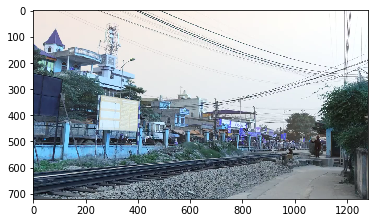

In [5]:
# To plot one frame
cap = cv2.VideoCapture('video.mp4')
ret, frame = cap.read()
plt.imshow(frame)

cap.release()
cv2.destroyAllWindows()

In [ ]:
# To play back the video
cap = cv2.VideoCapture('video.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

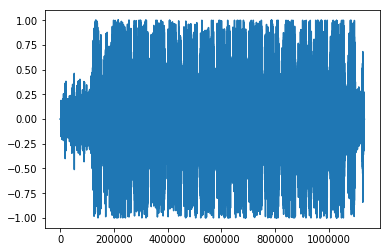

In [6]:
# Plot the time domain signal
data, samplerate = sf.read('audio.flac')
plt.plot(data)